# Chapter 4 word2vec 속도 개선
## 4.1 word2vec 개선 1
### 4.1.2 Embedding 계층 구현

In [18]:
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [19]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
    
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out
    
    def backward(self, dout):
        dW = self.grads
        dW[...] = 0

        for i, word_id in enumerate(self.idx):
            dW[word_id] += dout[i]

        return None

## 4.2 word2vec 개선 2
### 4.2.4 다중 분류에서 이진 분류로 (구현)

In [20]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None

    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)

        self.cache = (h, target_W)
        return out
    
    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)

        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh
    

### 4.2.7 네거티브 샘플링 구현

In [21]:
import collections
from common.np import *  # import numpy as np

class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]

        if not GPU:
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0
                p /= p.sum()
                negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
        else:
            # GPU(cupy）로 계산할 때는 속도를 우선한다.
            # 부정적 예에 타깃이 포함될 수 있다.
            negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size),
                                               replace=True, p=self.word_p)

        return negative_sample

In [22]:
from common.layers import Embedding, SigmoidWithLoss

class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size +1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size +1)]
        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads

    
    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)

        # 긍정적 예 순전파
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.zeros(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)

        # 부정적 예 순전파
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)
        
        return loss
    

    def backward(self, dout = 1):
        dh = 0 
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)

        return dh
    
    
            

### 4.3.1 CBOW 모델 구현

In [23]:
# coding: utf-8
import sys
sys.path.append('..')
from common.np import *  # import numpy as np
from common.layers import Embedding


class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        # 계층 생성
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  # Embedding 계층 사용
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        # 모든 가중치와 기울기를 배열에 모은다.
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss

    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None


### 4.3.2 CBOW 모델 학습 코드

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 1[s] | 손실 4.16
| 에폭 1 |  반복 41 / 9295 | 시간 2[s] | 손실 4.12
| 에폭 1 |  반복 61 / 9295 | 시간 3[s] | 손실 3.97
| 에폭 1 |  반복 81 / 9295 | 시간 4[s] | 손실 3.68
| 에폭 1 |  반복 101 / 9295 | 시간 5[s] | 손실 3.29
| 에폭 1 |  반복 121 / 9295 | 시간 6[s] | 손실 2.86
| 에폭 1 |  반복 141 / 9295 | 시간 7[s] | 손실 2.45
| 에폭 1 |  반복 161 / 9295 | 시간 8[s] | 손실 2.10
| 에폭 1 |  반복 181 / 9295 | 시간 9[s] | 손실 1.81
| 에폭 1 |  반복 201 / 9295 | 시간 10[s] | 손실 1.55
| 에폭 1 |  반복 221 / 9295 | 시간 11[s] | 손실 1.36
| 에폭 1 |  반복 241 / 9295 | 시간 12[s] | 손실 1.18
| 에폭 1 |  반복 261 / 9295 | 시간 13[s] | 손실 1.05
| 에폭 1 |  반복 281 / 9295 | 시간 14[s] | 손실 0.92
| 에폭 1 |  반복 301 / 9295 | 시간 15[s] | 손실 0.83
| 에폭 1 |  반복 321 / 9295 | 시간 16[s] | 손실 0.75
| 에폭 1 |  반복 341 / 9295 | 시간 17[s] | 손실 0.66
| 에폭 1 |  반복 361 / 9295 | 시간 18[s] | 손실 0.61
| 에폭 1 |  반복 381 / 9295 | 시간 19[s] | 손실 0.54
| 에폭 1 |  반복 401 / 9295 | 시간 20[s] | 손실 0.49
| 에폭 1 |  반복 421 / 9295 | 시간 21[s] | 손실 0.44
| 에폭 1 |  반복 441 / 9295 | 

c:\Users\Beom\deeplearning-from-scratch\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Beom\deeplearning-from-scratch\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Beom\deeplearning-from-scratch\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Beom\deeplearning-from-scratch\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


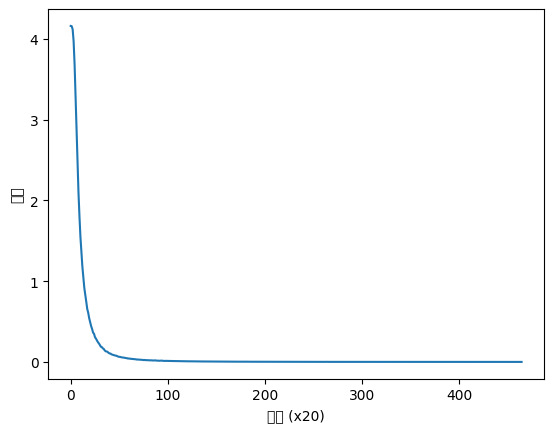

In [24]:

# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ===============================================
# config.GPU = True
# ===============================================
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
# from cbow import CBOW
# from skip_gram import SkipGram
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb


# 하이퍼파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
# max_epoch = 10
max_epoch = 1

# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

# 모델 등 생성
model = CBOW(vocab_size, hidden_size, window_size, corpus)
# model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'  # or 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)


### 4.3.3 CBOW 모델 평가

In [25]:
# coding: utf-8
import sys
sys.path.append('..')
from common.util import most_similar, analogy
import pickle


pkl_file = 'cbow_params.pkl'
# pkl_file = 'skipgram_params.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

# 가장 비슷한(most similar) 단어 뽑기
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

# 유추(analogy) 작업
print('-'*50)
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)


[query] you
 is: 1.0
 mr.: 1.0
 of: 1.0
 the: 1.0
 <eos>: 1.0

[query] year
 mr.: 1.0009765625
 are: 1.0009765625
 an: 1.0009765625
 board: 1.0
 the: 1.0

[query] car
 mr.: 1.0009765625
 workers: 1.0
 rep.: 1.0
 reported: 1.0
 with: 1.0

[query] toyota
 the: 0.9990234375
 to: 0.9990234375
 years: 0.9990234375
 revenue: 0.9990234375
 d.: 0.9990234375
--------------------------------------------------

[analogy] king:man = queen:?
 and: 9.1015625
 <eos>: 8.859375
 to: 8.734375
 's: 8.7265625
 of: 8.59375

[analogy] take:took = go:?
 and: 9.1875
 <eos>: 8.9375
 to: 8.8125
 's: 8.8046875
 of: 8.671875

[analogy] car:cars = child:?
 and: 9.125
 <eos>: 8.8828125
 to: 8.7578125
 's: 8.75
 of: 8.6171875

[analogy] good:better = bad:?
 and: 9.171875
 <eos>: 8.921875
 to: 8.796875
 's: 8.7890625
 of: 8.65625
